# Курсовой проект 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import random

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score as r2
from pylab import rcParams

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 12})

Импортирую данные для обучения модели, далее проверю совпадает ли количество признаков в обучающем и тестовом датасетах (за минусом столбца "Price").

In [5]:
DATASET_train = pd.read_csv('/home/eka/Документы/python for DS/Python  Data Science/train.csv')
DATASET_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
DATASET_test = pd.read_csv('/home/eka/Документы/python for DS/Python  Data Science/test.csv')
DATASET_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [7]:
DATASET_train.shape[1] - 1 == DATASET_test.shape[1]

True

Посмотрим распределение целевой переменнкой - видно, что сильных выбросов и скачков

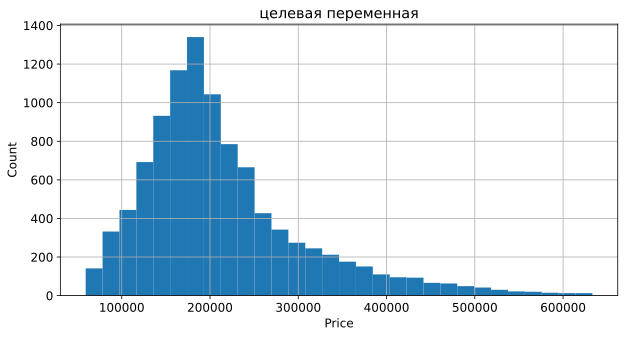

In [8]:
plt.figure(figsize = (10, 5))

DATASET_train['Price'].hist(bins=30)
plt.plot(color="green")

plt.title("целевая переменная")
plt.xlabel("Price")
plt.ylabel("Count")

plt.show()

Посмотрим статистики по датасетам. 
По обучающим и тестовым данным видны отклонения по Rooms, Square, LifeSquare, KitchenSquare, HouseFloor, Healthcare_1. Например, параметры LifeSquare и KitchenSquare - выше чем максимальная площадь квартиры, в LifeSquare и Healthcare_1 - пропущено много значений. 
Далее будем обрабатывать выбросы по этим отклонениям.

In [9]:
DATASET_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [10]:
DATASET_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### Обратобка выбросов - Rooms

Проверю статистику количества квартир по количеству комнат. Считаю, что значения 0, 6, 10, 17, 19 - это выбросы и заменю их на медиану. Проверю результат. 

In [11]:
DATASET_train['Rooms'].value_counts().sort_index()

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

In [12]:
# обратобка выбросов - комнаты
DATASET_test['Rooms'].value_counts().sort_index()

0.0        2
1.0     1769
2.0     2030
3.0     1099
4.0       90
5.0        7
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [13]:
DATASET_train.loc[DATASET_train['Rooms'].isin([0, 6, 10, 19]), 'Rooms'] = DATASET_train['Rooms'].median()
DATASET_test.loc[DATASET_test['Rooms'].isin([0, 6, 17]), 'Rooms'] = DATASET_train['Rooms'].median()

In [14]:
DATASET_train['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

In [15]:
DATASET_test['Rooms'].value_counts()

2.0    2035
1.0    1769
3.0    1099
4.0      90
5.0       7
Name: Rooms, dtype: int64

#### Обратобка выбросов - Square, LifeSquare, KitchenSquare

Необходимо преобразовать минимальные значения по площадям, т.к. значения 1.378543, 0.333490, 0.000000 являются выбросами, максимальные значения также необходимо обработать, т.к.значения LifeSquare, KitchenSquare больше чем Square.
LifeSquare - много пропусков которые необходимо заполнить.

In [16]:
stats = DATASET_train.groupby(["Rooms"])["Square"].mean()

In [17]:
DATASET_train['LifeSquare'].isnull().sum()

2113

In [18]:
DATASET_test['LifeSquare'].isnull().sum()

1041

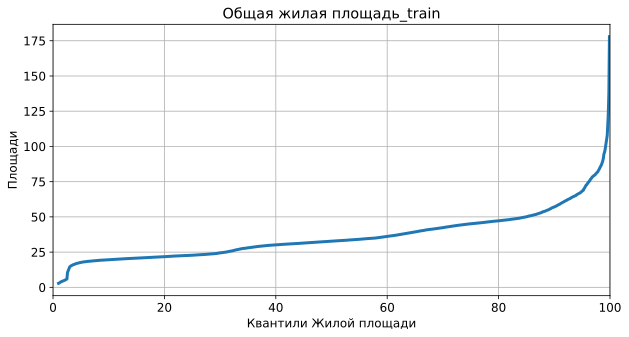

In [19]:
fig = plt.figure(figsize=(10, 5))

q = [np.percentile(DATASET_train["LifeSquare"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)

plt.title("Общая жилая площадь_train")
plt.xlabel("Квантили Жилой площади")
plt.ylabel("Площади")
plt.xlim(0, 100)
plt.grid()

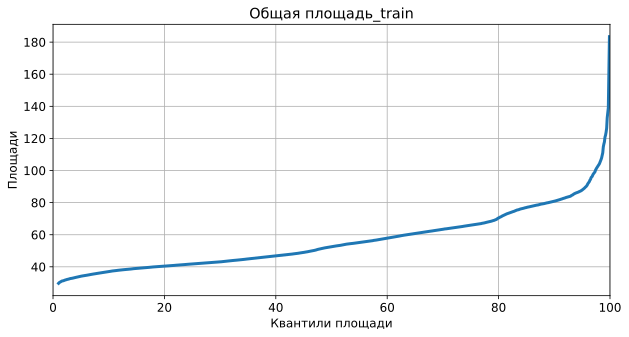

In [20]:
fig = plt.figure(figsize=(10, 5))

q = [np.percentile(DATASET_train["Square"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)

plt.title("Общая площадь_train")
plt.xlabel("Квантили площади")
plt.ylabel("Площади")
plt.xlim(0, 100)
plt.grid()

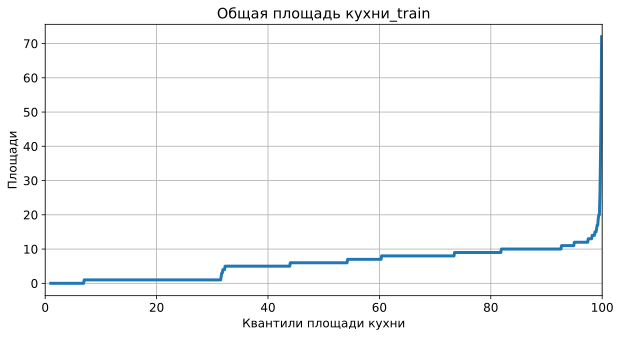

In [21]:
fig = plt.figure(figsize=(10, 5))

q = [np.percentile(DATASET_train["KitchenSquare"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)

plt.title("Общая площадь кухни_train")
plt.xlabel("Квантили площади кухни")
plt.ylabel("Площади")
plt.xlim(0, 100)
plt.grid()

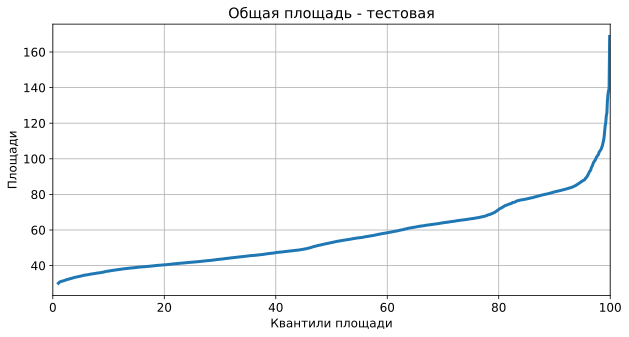

In [22]:
fig = plt.figure(figsize=(10, 5))

q = [np.percentile(DATASET_test["Square"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)

plt.title("Общая площадь - тестовая")
plt.xlabel("Квантили площади")
plt.ylabel("Площади")
plt.xlim(0, 100)
plt.grid()

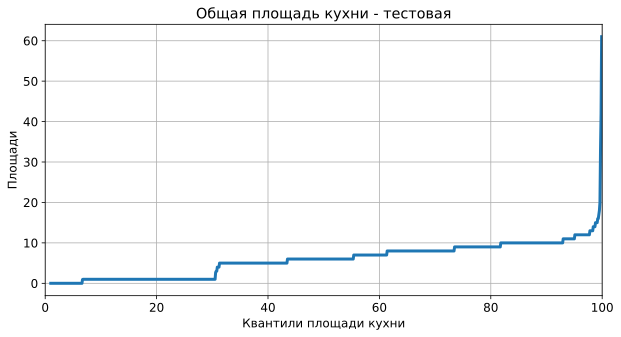

In [23]:
fig = plt.figure(figsize=(10, 5))

q = [np.percentile(DATASET_test["KitchenSquare"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)

plt.title("Общая площадь кухни - тестовая")
plt.xlabel("Квантили площади кухни")
plt.ylabel("Площади")
plt.xlim(0, 100)
plt.grid()

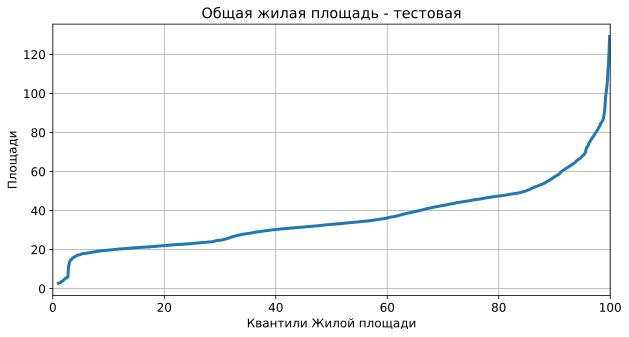

In [24]:
# обратобка выбросов - площади
fig = plt.figure(figsize=(10, 5))

q = [np.percentile(DATASET_test["LifeSquare"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)

plt.title("Общая жилая площадь - тестовая")
plt.xlabel("Квантили Жилой площади")
plt.ylabel("Площади")
plt.xlim(0, 100)
plt.grid()

Посмотрю квартиры, где общая площадь меньше суммы жилой площади и кухни

In [25]:
mask = DATASET_train["Square"] < DATASET_train["KitchenSquare"] + DATASET_train["LifeSquare"]
DATASET_train.loc[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
48,7596,23,1.0,47.080100,46.807989,12.0,3,9.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,96029.167877
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9897,4497,1,1.0,38.330353,38.010046,8.0,7,17.0,1991,0.025609,B,B,33,5261,0,240.0,3,1,B,97464.327338
9902,14001,73,1.0,44.098768,44.267551,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.404161
9910,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016
9918,14904,34,4.0,104.049130,99.788387,10.0,8,25.0,2018,0.069753,B,B,53,13670,4,NaN,1,11,B,411971.106869


Заменю выбросы Square, LifeSquare, KitchenSquare на экспертное значение

In [26]:
DATASET_train.loc[DATASET_train['LifeSquare'] < 10, 'LifeSquare'] = 10
DATASET_train.loc[DATASET_train['LifeSquare'] > 150, 'LifeSquare'] = 150
DATASET_train.loc[DATASET_train['KitchenSquare'] < 3, 'KitchenSquare'] = 3
DATASET_train.loc[DATASET_train['KitchenSquare'] > 25, 'KitchenSquare'] = 25
DATASET_train.loc[DATASET_train['Square'] < 15, 'Square'] = 15
DATASET_train.loc[DATASET_train['Square'] > 200, 'Square'] = 200

#### Обработаю ошибки в HouseFloor

Значение 0 в HouseFloor не может быть, т.к. количество этажей минимально 1. Поэтому заменю 0 на медиану

In [27]:
DATASET_train["HouseFloor"].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [28]:
DATASET_test["HouseFloor"].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.])

In [29]:
DATASET_train["Floor"].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [30]:
DATASET_test["Floor"].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78])

In [31]:
DATASET_train.loc[DATASET_train['HouseFloor'] == 0, 'HouseFloor'] = DATASET_train['HouseFloor'].median()
DATASET_test.loc[DATASET_test['HouseFloor'] == 0, 'HouseFloor'] = DATASET_test['HouseFloor'].median()

Найдем разницу в этажноси, где этаж на котором расположена квартира выше, чем всего этажей в доме.
Т.к. не ясно где ошибка, заменю этажность на рандомное количество из общего количества этажей в доме, чтобы исключить субъективность.

In [32]:
floor_delta_housefloor = DATASET_train['HouseFloor'] - DATASET_train['Floor']
floor_delta_housefloor = np.abs(floor_delta_housefloor[floor_delta_housefloor<0])
floor_delta_housefloor.value_counts().sort_index()

1.0     706
2.0     417
3.0      57
4.0      53
5.0      38
6.0      45
7.0      29
8.0      27
9.0      32
10.0     31
11.0     27
12.0     25
13.0     22
14.0     16
15.0     20
16.0     14
17.0      9
18.0      3
19.0      7
20.0      9
21.0      5
22.0      2
23.0      7
24.0      4
25.0      3
26.0      1
27.0      1
dtype: int64

In [33]:
floor_delta_housefloor = DATASET_test['HouseFloor'] - DATASET_test['Floor']
floor_delta_housefloor = np.abs(floor_delta_housefloor[floor_delta_housefloor<0])
floor_delta_housefloor.value_counts().sort_index()

1.0     350
2.0     215
3.0      19
4.0      31
5.0      20
6.0      23
7.0      17
8.0      16
9.0       9
10.0     15
11.0     13
12.0      4
13.0     13
14.0      6
15.0      7
16.0      4
17.0      7
18.0      1
19.0      5
20.0      5
21.0      2
22.0      3
23.0      3
24.0      2
26.0      1
56.0      1
dtype: int64

In [34]:
floor_outliers = DATASET_train[DATASET_train["Floor"] > DATASET_train["HouseFloor"]].index

DATASET_train.loc[floor_outliers, "Floor"] = DATASET_train.loc[floor_outliers, "HouseFloor"].apply(
    lambda x: random.randint(1, x)
)

In [35]:
floor_outliers = DATASET_test[DATASET_test["Floor"] > DATASET_test["HouseFloor"]].index

DATASET_test.loc[floor_outliers, "Floor"] = DATASET_test.loc[floor_outliers, "HouseFloor"].apply(
    lambda x: random.randint(1, x)
)

In [36]:
DATASET_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888400,56.215045,36.252955,6.466900,7.416100,12.95910,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.811056,19.195861,17.477878,3.280149,5.041478,6.44346,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,1.000000,15.000000,10.000000,3.000000,1.000000,1.00000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,3.000000,3.000000,9.00000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,6.000000,13.00000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,11.000000,17.00000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,5.000000,200.000000,150.000000,25.000000,42.000000,117.00000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [37]:
DATASET_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.906200,56.449500,36.158810,5.976800,7.483200,12.915400,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.805935,19.092787,17.825287,9.950018,5.155951,6.468617,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,1.000000,1.378543,0.333490,0.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,6.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,10.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,5.000000,223.453689,303.071094,620.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### Обработаю ошибки в HouseYear в обучающем датасете

In [38]:
DATASET_train['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
1499        2020
5701        2020
7076        2020
          ...   
7611        1916
910         1914
5111        1912
2656        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [39]:
DATASET_test['HouseYear'].sort_values(ascending=False)

4389    2020
4273    2020
888     2020
3255    2020
1039    2020
        ... 
1475    1912
64      1911
2691    1910
2       1909
3253    1908
Name: HouseYear, Length: 5000, dtype: int64

In [40]:
DATASET_train.loc[DATASET_train['HouseYear'] > 5000, 'HouseYear'] = 2020
DATASET_train.loc[DATASET_train['HouseYear'] == 4968, 'HouseYear'] = 1968

In [41]:
DATASET_train['HouseYear'].sort_values(ascending=False)

1497    2020
585     2020
2493    2020
5701    2020
790     2020
        ... 
7611    1916
910     1914
2656    1912
5111    1912
9317    1910
Name: HouseYear, Length: 10000, dtype: int64

#### Обработка пропусков LifeSquare  и Healthcare_1 

Для обработки пропусков LifeSquare - берем разницу месжду общей площадью, площадью кухни и неучтенной площадю (коридоры, санузлы, технические помещения)

In [42]:
square_med_diff = (DATASET_train.loc[DATASET_train["LifeSquare"].notnull(), "Square"] -\
                   DATASET_train.loc[DATASET_train["LifeSquare"].notnull(), "LifeSquare"] -\
                   DATASET_train.loc[DATASET_train["LifeSquare"].notnull(), "KitchenSquare"]).median()
square_med_diff


11.370487069339717

In [43]:
DATASET_train.loc[DATASET_train["LifeSquare"].isnull(), "LifeSquare"] =\
DATASET_train.loc[DATASET_train["LifeSquare"].isnull(), "Square"] -\
DATASET_train.loc[DATASET_train["LifeSquare"].isnull(), "KitchenSquare"] -\
square_med_diff

In [44]:
DATASET_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888400,56.215045,38.169665,6.466900,7.416100,12.95910,1984.867200,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.811056,19.195861,18.381552,3.280149,5.041478,6.44346,18.413769,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,1.000000,15.000000,3.043694,3.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,24.203338,3.000000,3.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,33.778099,6.000000,6.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,47.181544,9.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,5.000000,200.000000,185.629513,25.000000,42.000000,117.00000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [45]:
square_med_diff_test = (DATASET_test.loc[DATASET_test["LifeSquare"].notnull(), "Square"] -\
                       DATASET_test.loc[DATASET_test["LifeSquare"].notnull(), "LifeSquare"] -\
                       DATASET_test.loc[DATASET_test["LifeSquare"].notnull(), "KitchenSquare"]).median()
square_med_diff_test


11.38738439736359

In [46]:
DATASET_test.loc[DATASET_test["LifeSquare"].isnull(), "LifeSquare"] =\
DATASET_test.loc[DATASET_test["LifeSquare"].isnull(), "Square"] -\
DATASET_test.loc[DATASET_test["LifeSquare"].isnull(), "KitchenSquare"] -\
square_med_diff_test

In [47]:
DATASET_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.906200,56.449500,38.536872,5.976800,7.483200,12.915400,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.805935,19.092787,18.672918,9.950018,5.155951,6.468617,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,1.000000,1.378543,-10.061341,0.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,24.836830,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,34.319076,6.000000,6.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,47.839983,9.000000,10.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,5.000000,223.453689,303.071094,620.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


для Healthcare_1 - укажем моду, т.к. не знаем что изначают цифры в данном столбце

In [92]:
DATASET_train["Healthcare_1"].mode()[0]

9.0

In [93]:
DATASET_test["Healthcare_1"].mode()

0    540.0
dtype: float64

In [50]:
DATASET_train.loc[DATASET_train["Healthcare_1"].isnull(), "Healthcare_1"] = 9
DATASET_test.loc[DATASET_test["Healthcare_1"].isnull(), "Healthcare_1"] = 540

In [51]:
DATASET_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888400,56.215045,38.169665,6.466900,7.416100,12.95910,1984.867200,0.118858,24.687000,5352.157400,8.039200,598.857100,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.811056,19.195861,18.381552,3.280149,5.041478,6.44346,18.413769,0.119025,17.532614,4006.799803,23.831875,929.365176,1.493601,4.806341,92872.293865
min,0.00000,0.000000,1.000000,15.000000,3.043694,3.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,24.203338,3.000000,3.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,9.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,33.778099,6.000000,6.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,30.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,47.181544,9.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,5.000000,200.000000,185.629513,25.000000,42.000000,117.00000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [52]:
DATASET_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.906200,56.449500,38.536872,5.976800,7.483200,12.915400,1984.392600,0.119874,24.933800,5406.900000,8.262600,858.252400,1.31940,4.242800
std,4832.674037,44.179466,0.805935,19.092787,18.672918,9.950018,5.155951,6.468617,18.573149,0.120070,17.532202,4026.614773,23.863762,815.043571,1.47994,4.777365
min,1.000000,0.000000,1.000000,1.378543,-10.061341,0.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,24.836830,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,540.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,34.319076,6.000000,6.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,540.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,47.839983,9.000000,10.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,16795.000000,212.000000,5.000000,223.453689,303.071094,620.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [53]:
DATASET_train["Healthcare_1"].value_counts()

9.0       4798
540.0      511
30.0       348
1046.0     245
750.0      163
          ... 
370.0       14
32.0        12
1815.0      10
35.0         2
0.0          1
Name: Healthcare_1, Length: 80, dtype: int64

Проверяю есть ли пропуски

In [54]:
len(DATASET_train) - DATASET_train.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [55]:
len(DATASET_test) - DATASET_test.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

#### Построение новых признаков на основе группировки

Добавлю новые признаки для лучшего обучения модели.

Сгруппирую данные по комнатам, посчитаю средную площадь по комнатам и разность площади в этой квартире и средней площадью по всем квартирам с таким же количеством комнат.

In [56]:
gb = DATASET_train.groupby(["Rooms"])["Square"].mean()
DATASET_train["Mean_Square_by_rooms"] = DATASET_train["Rooms"].map(gb.to_dict())

DATASET_train["diff_square_and_mean_square_by_rooms"] = DATASET_train["Square"] - DATASET_train["Mean_Square_by_rooms"]
DATASET_train["ratio_square_and_mean_square_by_rooms"] = DATASET_train["Square"] / DATASET_train["Mean_Square_by_rooms"] - 1
DATASET_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,9.0,0,11,B,184966.930730,56.622817,-8.641255,-0.152611
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.450063,76.913078,-11.229438,-0.146002
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.908524,56.622817,-11.674864,-0.206187
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.227217,56.622817,-3.269835,-0.057748
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531644,41.291767,-1.642575,-0.039780


In [57]:
gb = DATASET_test.groupby(["Rooms"])["Square"].mean()
DATASET_test["Mean_Square_by_rooms"] = DATASET_test["Rooms"].map(gb.to_dict())

DATASET_test["diff_square_and_mean_square_by_rooms"] = DATASET_test["Square"] - DATASET_test["Mean_Square_by_rooms"]
DATASET_test["ratio_square_and_mean_square_by_rooms"] = DATASET_test["Square"] / DATASET_test["Mean_Square_by_rooms"] - 1
DATASET_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,11,2748,1,540.0,0,0,B,56.834989,-6.952345,-0.122325
1,15856,74,2.0,69.263183,56.875799,1.0,1,1.0,1977,0.075779,...,6,1437,3,540.0,0,2,B,56.834989,12.428195,0.218672
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,30,7538,87,4702.0,5,5,B,40.943143,-27.345325,-0.667885
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,23,4583,3,540.0,3,3,B,56.834989,16.211621,0.285240
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,2,629,1,540.0,0,0,A,40.943143,6.583967,0.160808


В категориях Ecology_2 и Ecology_3 заменю бинарные значения на числовые 0 и 1. Далее объединю.

In [58]:
DATASET_train["Ecology_2_bin"] = DATASET_train["Ecology_2"].replace({"A":0, "B":1})
DATASET_train["Ecology_3_bin"] = DATASET_train["Ecology_3"].replace({"A":0, "B":1})
DATASET_train["Shops_2_bin"] = DATASET_train["Shops_2"].replace({"A":0, "B":1})

DATASET_test["Ecology_2_bin"] = DATASET_test["Ecology_2"].replace({"A":0, "B":1})
DATASET_test["Ecology_3_bin"] = DATASET_test["Ecology_3"].replace({"A":0, "B":1})
DATASET_test["Shops_2_bin"] = DATASET_test["Shops_2"].replace({"A":0, "B":1})

In [59]:
DATASET_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,56.622817,-8.641255,-0.152611,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,76.913078,-11.229438,-0.146002,1,1,1
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,1,3,B,220925.908524,56.622817,-11.674864,-0.206187,1,1,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,56.622817,-3.269835,-0.057748,1,1,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,41.291767,-1.642575,-0.039780,1,1,1


In [60]:
DATASET_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,540.0,0,0,B,56.834989,-6.952345,-0.122325,1,1,1
1,15856,74,2.0,69.263183,56.875799,1.0,1,1.0,1977,0.075779,...,540.0,0,2,B,56.834989,12.428195,0.218672,1,1,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,4702.0,5,5,B,40.943143,-27.345325,-0.667885,1,1,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,540.0,3,3,B,56.834989,16.211621,0.285240,1,1,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,540.0,0,0,A,40.943143,6.583967,0.160808,1,1,0


Построим признаки на основе таргета по району - популярность районов

In [61]:
district_size = DATASET_train["DistrictId"].value_counts().reset_index()\
.rename(columns={"index":"DistrictId", "DistrictId":"DistrictSize"})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [62]:
district_size_test = DATASET_test["DistrictId"].value_counts().reset_index()\
.rename(columns={"index":"DistrictId", "DistrictId":"DistrictSize"})

district_size_test.head()

,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132


In [63]:
DATASET_train = DATASET_train.merge(district_size, on="DistrictId", how='left')
DATASET_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,11,B,184966.930730,56.622817,-8.641255,-0.152611,1,1,1,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,16,B,300009.450063,76.913078,-11.229438,-0.146002,1,1,1,87
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,3,B,220925.908524,56.622817,-11.674864,-0.206187,1,1,1,174
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5,B,175616.227217,56.622817,-3.269835,-0.057748,1,1,1,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,4,B,150226.531644,41.291767,-1.642575,-0.039780,1,1,1,97


In [64]:
DATASET_test = DATASET_test.merge(district_size_test, on="DistrictId", how='left')
DATASET_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,0,0,B,56.834989,-6.952345,-0.122325,1,1,1,91
1,15856,74,2.0,69.263183,56.875799,1.0,1,1.0,1977,0.075779,...,0,2,B,56.834989,12.428195,0.218672,1,1,1,61
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,5,5,B,40.943143,-27.345325,-0.667885,1,1,1,2
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,3,B,56.834989,16.211621,0.285240,1,1,1,49
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,0,0,A,40.943143,6.583967,0.160808,1,1,0,391


In [65]:
(DATASET_train['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [66]:
(DATASET_test['DistrictSize'] > 100).value_counts()

False    3375
True     1625
Name: DistrictSize, dtype: int64

In [67]:
DATASET_train['IsDistrictLarge'] = (DATASET_train["DistrictSize"] > 100).astype(int)
DATASET_test['IsDistrictLarge'] = (DATASET_test["DistrictSize"] > 100).astype(int)

Text(0, 0.5, 'Price')

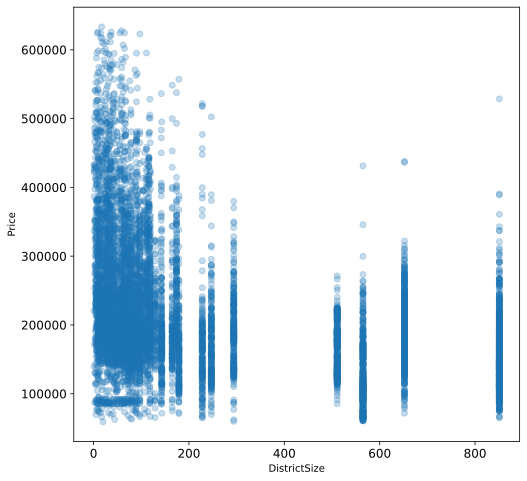

In [68]:
plt.figure(figsize=(8,8))
plt.scatter(
    DATASET_train["DistrictSize"], DATASET_train["Price"], alpha=0.25
)
plt.xlabel("DistrictSize", size=10)
plt.ylabel("Price", size=10)

Основная масса расположена в значениях DistrictSize до 170, цена изменяется в каждой группе хаотично.
Дальше признаки группирую и по району и комнатности и считаю средную стоимость. 

In [69]:
med_price_by_district = DATASET_train.groupby(["DistrictId", "Rooms"], as_index=False)\
.agg({"Price":'median'}).rename(columns={"Price":"MedPriceByDistrict"})

In [70]:
DATASET_train = DATASET_train.merge(med_price_by_district, on=["DistrictId", "Rooms"], how='left')
DATASET_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,184966.930730,56.622817,-8.641255,-0.152611,1,1,1,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,300009.450063,76.913078,-11.229438,-0.146002,1,1,1,87,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,220925.908524,56.622817,-11.674864,-0.206187,1,1,1,174,1,263206.223152
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,175616.227217,56.622817,-3.269835,-0.057748,1,1,1,179,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,150226.531644,41.291767,-1.642575,-0.039780,1,1,1,97,0,158539.052715


In [71]:
#перенос на тестовую выборку - распределить по работе
DATASET_test["DistrictId"] = DATASET_test["DistrictId"].astype(int)

In [72]:
DATASET_test.merge(med_price_by_district, on=["DistrictId", "Rooms"], how='left')
DATASET_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,0,B,56.834989,-6.952345,-0.122325,1,1,1,91,0
1,15856,74,2.0,69.263183,56.875799,1.0,1,1.0,1977,0.075779,...,2,B,56.834989,12.428195,0.218672,1,1,1,61,0
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,5,B,40.943143,-27.345325,-0.667885,1,1,1,2,0
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,B,56.834989,16.211621,0.285240,1,1,1,49,0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,0,A,40.943143,6.583967,0.160808,1,1,0,391,1


#### Подготовка данных и отбор признаков



In [73]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
                 'HouseYear', 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1','Shops_2_bin']
feature_names_new = ['IsDistrictLarge']
target_name = "Price"

In [74]:
feature_names_new.remove("IsDistrictLarge")

In [75]:
DATASET_train.shape

(10000, 29)

Разбиваю данные на обучающую и валидационную часть, и потом провожу обучение на этих данных

In [76]:
X = DATASET_train[feature_names + feature_names_new]
y = DATASET_train[target_name]

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [78]:
X_train.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1',
       'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
       'Shops_2_bin'],
      dtype='object')

In [79]:
X_train.isnull().sum()

Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2_bin    0
Ecology_3_bin    0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2_bin      0
dtype: int64

In [80]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=1000, max_depth=9, max_features=7, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, max_features=7, n_estimators=1000,
                      random_state=42)

Обценю качество модели, для этого добавляю функцию, которая считает метрику r2 по переданным наборам данных и построю графики.

In [81]:
# 
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):

    r2_train = r2(train_true_values, train_pred_values)
    print(f'r2_train = {r2_train}')
    
    r2_test = r2(test_true_values, test_pred_values)
    print(f'r2_test = {r2_test}')
    
    plt.figure(figsize=(10,7))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.title("Train sample prediction")
    plt.xlabel("train_pred_values")
    plt.ylabel("train_true_values")

    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.title("Test sample prediction")
    plt.xlabel("test_pred_values")
    plt.ylabel("test_true_values")

    plt.show()

r2_train = 0.8193083416833493
r2_test = 0.705689384502749


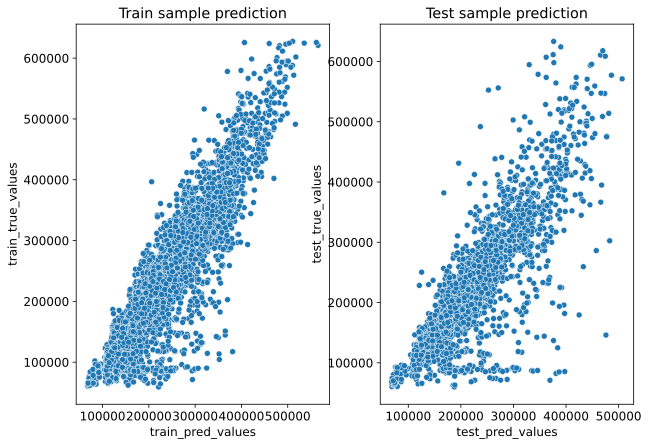

In [82]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate_preds(y_train, y_train_pred, y_test, y_test_pred)

Предсказываю цены для тестового датасета и выгружаю результат в файл. 

In [83]:
DATASET_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,0,B,56.834989,-6.952345,-0.122325,1,1,1,91,0
1,15856,74,2.0,69.263183,56.875799,1.0,1,1.0,1977,0.075779,...,2,B,56.834989,12.428195,0.218672,1,1,1,61,0
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,5,B,40.943143,-27.345325,-0.667885,1,1,1,2,0
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,B,56.834989,16.211621,0.285240,1,1,1,49,0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,0,A,40.943143,6.583967,0.160808,1,1,0,391,1


In [84]:
X_new = DATASET_test[feature_names + feature_names_new]

In [85]:
X_new.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin
0,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,11,2748,1,540.0,0,0,1
1,2.0,69.263183,56.875799,1.0,1,1.0,1977,0.075779,1,1,6,1437,3,540.0,0,2,1
2,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1
3,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,4583,3,540.0,3,3,1
4,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,1,2,629,1,540.0,0,0,0


In [86]:
X_new.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1',
       'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
       'Shops_2_bin'],
      dtype='object')

In [87]:
y_pred_new = model.predict(X_new)

In [88]:
predictions = pd.DataFrame({
    'Id': X_new.index,
    'Price': y_pred_new
})

In [89]:
predictions.describe()

,Id,Price
count,5000.000000,5000.000000
mean,2499.500000,216075.034767
std,1443.520003,73473.983831
min,0.000000,70046.559460
25%,1249.750000,169491.570803
50%,2499.500000,196641.904895
75%,3749.250000,250127.356665
max,4999.000000,560400.545665


In [90]:
predictions.to_csv('EShmyr_predictions.csv', index=False)

In [91]:
predictions.shape

(5000, 2)

Вывод:
Работа выполнена с помощью RandomForestRegressor.
Значение r2 = 0.70568, что больше 0,6.
Файл predictions.csv содержит два поля: Id, Price и в файле 5001 строка.